# Models
Different models are used for the following calculations:

## Vogel-Fulcher-Tammann (VFT)
$$
    Q_{\text{use}}(t, T) = Q_0(t)\exp\!\left( \frac{\alpha}{T - \beta} - \frac{\alpha}{T_{\text{ref}} - \beta} \right) = \kappa(T)Q_0(t), \\
    \kappa(T) \triangleq \exp\!\left( \frac{\alpha}{T - \beta} - \frac{\alpha}{T_{\text{ref}} - \beta} \right).
$$

## Forgez lumped model (FL)
$$
    \dot{T}_s = \frac{T_{\text{amb}} - T_s}{C_p(R_{\text{in}} + R_{\text{out}})} + \frac{R_{\text{out}}}{C_p(R_{\text{in}} + R_{\text{out}})}h_{\text{gen}}.
$$

## Bernardi model
$$
    h_{\text{gen}}(T) = I\left( V_{\text{oc}} - V \right) - IT\frac{\partial V_{\text{oc}}}{\partial T}.
$$

# Calculations
## State of Charge
Using these models, two different states of charge can be considered. $\text{SoC}_0(t)$ is the ignorant SoC, representing the SoC of the battery without consideration of thermal effects (i.e.\@ the SoC only considering nominal capacity and degradation), given by
$$
\text{SoC}_0(t) = \frac{Q(t)}{Q_0(t)},
$$
where $Q(t)$ is the current charge and $Q_0(t)$ is the current capacity. On the other hand, $\text{SoC}(t, T)$ corresponds to the ``real'' (or usable) SoC, which considers temperature as well as degradation effects, given by
$$
\text{SoC}(t, T) = \frac{Q(t)}{Q_{\text{use}}(t, T)},
$$
from which it can be easily seen that the following relation holds
$$
\text{SoC}(t, T) = \frac{1}{\kappa(T)}\text{SoC}_0(t),
$$
showing a relation between the two states of charge. This usable SoC is replaced in the electrical models of the battery, indicating that the battery actually uses this SoC, as opposed to current models where thermal effects are not considered.

## Open Circuit Voltage (VOC)
In the Bernardi model, the term
$$
IT\frac{\partial V_{\text{oc}}}{\partial T}
$$
models the heat generation due to entropic changes. From the literature it is know that VOC depends on both SoC and temperature. However, that second dependency has only been explored empirically, so one of the goals is to propose a model that correctly predicts temperature effects on VOC.

The first dependency that can be explored is, given a certain model for the VOC/SoC relation, how does the temperature effect on SoC affect the VOC. For this, from the chain rule we can calculate
$$
\frac{\partial V_{\text{oc}}}{\partial T} = \frac{\partial V_{\text{oc}}}{\partial \text{SoC}} \frac{\partial \text{SoC}}{\partial T}.
$$

The first derivative is given by the chosen VOC/SoC model, so it is ignored. For the second one, through the calculated relation between SoC and $\text{SoC}_0$ we can calculate
$$
\frac{\partial \text{SoC}}{\partial T} = \frac{\alpha}{{\left( T - \beta \right)}^2 \kappa}\text{SoC}_0,
$$
so the entropic term can be expressed as
$$
\frac{\partial V_{\text{oc}}}{\partial T} = \frac{\alpha}{{\left( T - \beta \right)}^2 \kappa}\text{SoC}_0 \frac{\partial V_{\text{oc}}}{\partial \text{SoC}}.
$$

Another consideration that could be taken is that VOC depends on ignorant SoC rather than usable SoC. Thus, considering
$$
\frac{\partial V_{\text{oc}}}{\partial \text{SoC}} = \frac{\partial V_{\text{oc}}}{\partial \text{SoC}_0} \frac{\partial \text{SoC}_0}{\partial \text{SoC}},
$$
the entropic term can be instead expressed as
$$
\frac{\partial V_{\text{oc}}}{\partial T} = \frac{\alpha}{{\left( T - \beta \right)}^2}\text{SoC}_0 \frac{\partial V_{\text{oc}}}{\partial \text{SoC}_0}.
$$

# Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("tableau-colorblind10")


In [34]:
# Temperature model parameters
T_REF = 2.730e2
ALPHA = -5.738
BETA = 2.099e2

# Open-circuit voltage curve parameters
OCV_1 = -5.863e-1
OCV_2 = 21.9
OCV_3 = 3.414
OCV_4 = 1.102e-1
OCV_5 = -1.718e-1
OCV_6 = 8.0e-3

# Simulation parameters
EPSILON = 1e-9
ZERO_CELSIUS_IN_KELVIN = 273

def calculate_soc_coeff(temperature, t_ref=T_REF, a=ALPHA, b=BETA):
    return np.exp(a / (temperature - b) - a / (t_ref - b))


def calculate_soc_with_temperature(soc, temperature, t_ref=T_REF, a=ALPHA, b=BETA):
    return soc / calculate_soc_coeff(temperature, t_ref, a, b)


def calculate_ocv(soc, a1=OCV_1, a2=OCV_2, a3=OCV_3, a4=OCV_4, a5=OCV_5, a6=OCV_6):
    return a1 * np.exp(-a2 * soc) + a3 + a4 * soc + a5 * np.exp(-a6 / (1 - soc))


def calculate_ocv_grad(soc, a1=OCV_1, a2=OCV_2, a3=OCV_3, a4=OCV_4, a5=OCV_5, a6=OCV_6):
    return -a1 * a2 * np.exp(-a2 * soc) + a4 - a5 * a6 * np.exp(-a6 / (1 - soc)) / ((1 - soc) ** 2)


def calculate_entropy_change(temperature, soc, a=ALPHA, b=BETA, a1=OCV_1, a2=OCV_2, a3=OCV_3, a4=OCV_4, a5=OCV_5, a6=OCV_6):
    return (a / ((temperature - b)**2)) * soc * calculate_ocv_grad(soc, a1, a2, a3, a4, a5, a6)


def calculate_entropy_change_kappa(temperature, soc, t_ref=T_REF, a=ALPHA, b=BETA, a1=OCV_1, a2=OCV_2, a3=OCV_3, a4=OCV_4, a5=OCV_5, a6=OCV_6):
    return (a / ((temperature - b)**2 * calculate_soc_coeff(temperature, t_ref, a, b))) * soc * calculate_ocv_grad(soc, a1, a2, a3, a4, a5, a6)


# Functions for temperature
def celsius_to_kelvin(deg):
    return ZERO_CELSIUS_IN_KELVIN + deg


def kelvin_to_celsius(deg):
    return deg - ZERO_CELSIUS_IN_KELVIN


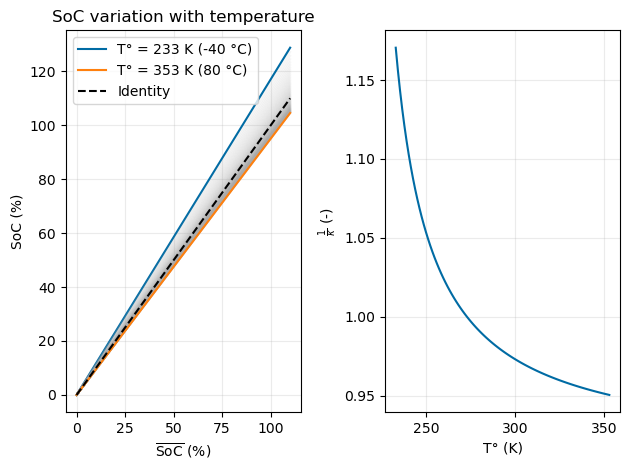

In [35]:
fig, (ax, ax_coeff) = plt.subplots(1, 2)
soc = np.linspace(0, 1.1, 100)
temperatures = np.linspace(celsius_to_kelvin(-40), celsius_to_kelvin(80), 100)

for t in temperatures:
    soc_t = calculate_soc_with_temperature(soc, t)
    if t == temperatures[0] or t == temperatures[-1]:
        ax.plot(100 * soc, 100 * soc_t, label=f"T° = {t:.0f} K ({kelvin_to_celsius(t):.0f} °C)")
    else:
        ax.plot(100 * soc, 100 * soc_t, alpha=0.1, color="#aaa")
ax.plot(100 * soc, 100 * soc, linestyle="--", color="#000", label="Identity")
ax.set_title("SoC variation with temperature")
ax.grid(alpha=0.25)
ax.set_xlabel(r"$\overline{\text{SoC}}$ (%)")
ax.set_ylabel("SoC (%)")
ax.legend()

ax_coeff.plot(temperatures, 1 / calculate_soc_coeff(temperatures))
ax_coeff.grid(alpha=0.25)
ax_coeff.set_xlabel("T° (K)")
ax_coeff.set_ylabel(r"$\frac{1}{\kappa}$ (-)")

fig.tight_layout()

plt.show()


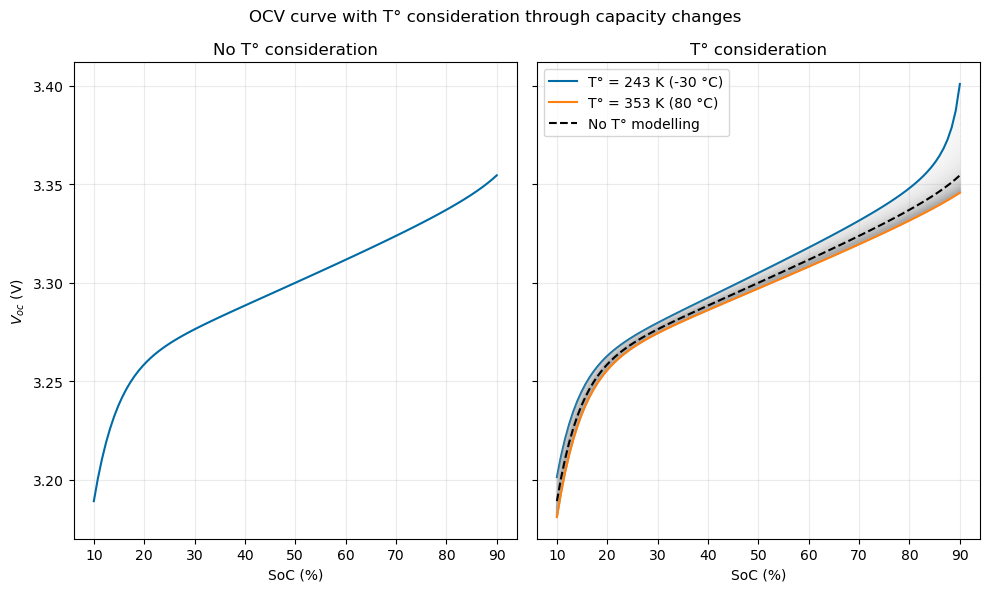

In [36]:
fig, (ax, ax_t) = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=True)
soc = np.linspace(0.1, 0.9, 100)
temperatures = np.linspace(celsius_to_kelvin(-30), celsius_to_kelvin(80), 100)

ax.plot(100 * soc, calculate_ocv(soc))
ax.set_title("No T° consideration")
ax.grid(alpha=0.25)
ax.set_xlabel("SoC (%)")
ax.set_ylabel("$V_{{oc}}$ (V)")

for t in temperatures:
    soc_t = calculate_soc_with_temperature(soc, t)
    ocv = calculate_ocv(soc_t)
    if t == temperatures[0] or t == temperatures[-1]:
        ax_t.plot(100 * soc, ocv, label=f"T° = {t:.0f} K ({kelvin_to_celsius(t):.0f} °C)")
    else:
        ax_t.plot(100 * soc, ocv, alpha=0.1, color="#aaa")
ax_t.plot(100 * soc, calculate_ocv(soc), linestyle="--", color="#000", label="No T° modelling")
ax_t.set_title("T° consideration")
ax_t.grid(alpha=0.25)
ax_t.set_xlabel("SoC (%)")
# ax_t.set_ylabel("$V_{{oc}}$ (V)")
ax_t.legend()

fig.suptitle("OCV curve with T° consideration through capacity changes")
fig.tight_layout()

plt.show()


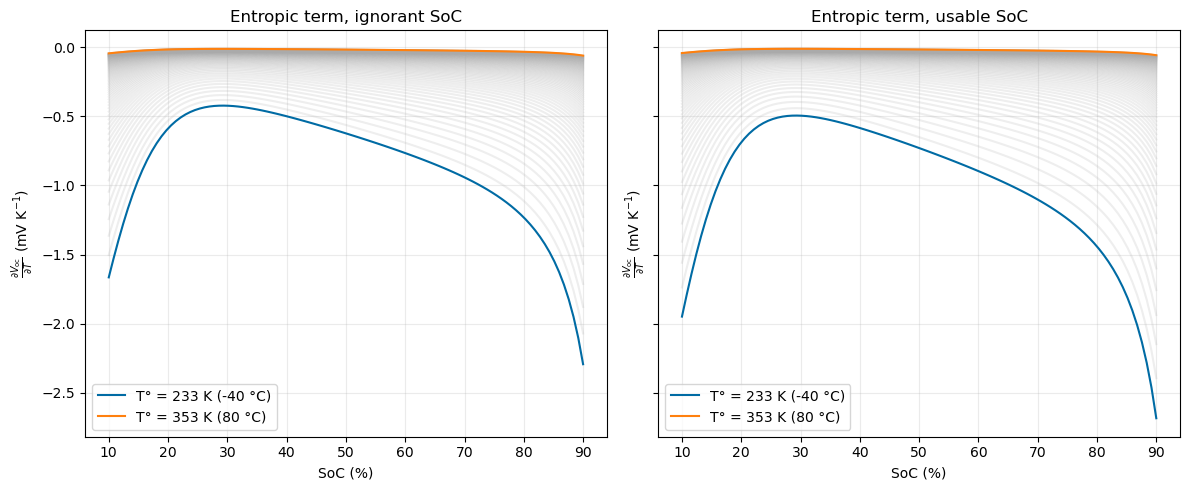

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
soc = np.linspace(0.1, 0.9, 100)
temperatures = np.linspace(celsius_to_kelvin(-40), celsius_to_kelvin(80), 100)

for t in temperatures:
    if t == temperatures[0] or t == temperatures[-1]:
        ax1.plot(100 * soc, 1e3 * calculate_entropy_change(t, soc), label=f"T° = {t:.0f} K ({kelvin_to_celsius(t):.0f} °C)")
        ax2.plot(100 * soc, 1e3 * calculate_entropy_change_kappa(t, soc), label=f"T° = {t:.0f} K ({kelvin_to_celsius(t):.0f} °C)")
    else:
        ax1.plot(100 * soc, 1e3 * calculate_entropy_change(t, soc), alpha=0.2, color="#aaa")
        ax2.plot(100 * soc, 1e3 * calculate_entropy_change_kappa(t, soc), alpha=0.2, color="#aaa")

ax1.set_title("Entropic term, ignorant SoC")
ax1.grid(alpha=0.25)
ax1.set_xlabel("SoC (%)")
ax1.set_ylabel(r"$\frac{\partial V_{\text{oc}}}{\partial T}$ (mV K$^{-1}$)")
ax1.legend()

ax2.set_title("Entropic term, usable SoC")
ax2.grid(alpha=0.25)
ax2.set_xlabel("SoC (%)")
ax2.set_ylabel(r"$\frac{\partial V_{\text{oc}}}{\partial T}$ (mV K$^{-1}$)")
ax2.legend()

fig.tight_layout()

plt.show()
